In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls "/content/drive/MyDrive/resizes-images"

BrownSpot  Healthy  Hispa  LeafBlast


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Input
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array , array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten , Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense


In [4]:
def convert_image_to_array(image_dir):
  try:
      image = cv2.imread(image_dir)
      if image is not None :
         image = cv2.resize(image, (299, 299))
         return img_to_array(image)
      else :
        return np.array([])
  except Exception as e:
        print(f"Error : {e}")
        return None


In [5]:
import os

dir = "/content/drive/MyDrive/resizes-images"
image_list, label_list = [], []
all_labels = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
binary_labels = [0, 1, 2, 3]
temp = -1

for directory in all_labels:
    plant_image_list = os.listdir(f"{dir}/{directory}")
    temp += 1
    for files in plant_image_list:
        image_path = f"{dir}/{directory}/{files}"
        image_list.append(convert_image_to_array(image_path))
        label_list.append(binary_labels[temp])


In [6]:
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

3    623
2    452
1    397
0     56
dtype: int64

In [7]:
image_list[0].shape

(299, 299, 3)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10)


In [9]:
x_train = np.array(x_train, dtype=np.float16)/255.0
x_test = np.array(x_test, dtype=np.float16)/255.0
x_train = x_train.reshape(-1, 299, 299, 3)
x_test = x_test.reshape(-1, 299, 299, 3)



In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [14]:
# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True)



/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
39/39 [==============================] - 37s 569ms/step - loss: 1.2614 - accuracy: 0.3609 - val_loss: 1.1520 - val_accuracy: 0.4542
Epoch 2/10
39/39 [==============================] - 11s 286ms/step - loss: 1.1605 - accuracy: 0.4280 - val_loss: 1.1347 - val_accuracy: 0.4444
Epoch 3/10
39/39 [==============================] - 11s 287ms/step - loss: 1.1186 - accuracy: 0.4640 - val_loss: 1.1914 - val_accuracy: 0.4085
Epoch 4/10
39/39 [==============================] - 11s 282ms/step - loss: 1.1337 - accuracy: 0.4403 - val_loss: 1.1544 - val_accuracy: 0.4412
Epoch 5/10
39/39 [==============================] - 11s 291ms/step - loss: 1.0926 - accuracy: 0.4861 - val_loss: 1.0804 - val_accuracy: 0.5229
Epoch 6/10
39/39 [==============================] - 11s 288ms/step - loss: 1.0729 - accuracy: 0.4885 - val_loss: 1.0989 - val_accuracy: 0.4771
Epoch 7/10
39/39 [==============================] - 12s 303ms/step - loss: 1.0568 - accuracy: 0.5090 - val_loss: 1.0735 - val_accuracy: 0.5294

In [16]:
# Load the best weights
model.load_weights('best_model.h5')

In [17]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy}')

10/10 [==============================] - 2s 228ms/step - loss: 1.0494 - accuracy: 0.5458
Test accuracy: 0.5457516312599182


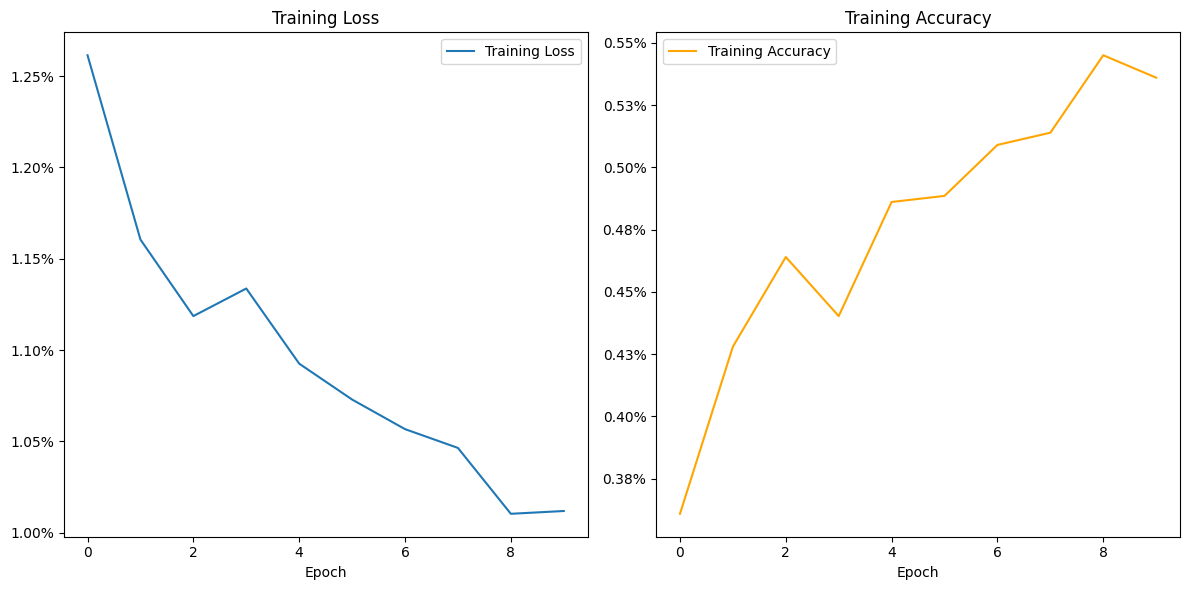

Overall Loss: 1.0119
Overall Accuracy: 0.5360


In [18]:
# Plot loss and accuracy graphs
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))
plt.legend()

plt.tight_layout()
plt.show()

# Print overall accuracy and loss
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]

print(f"Overall Loss: {final_loss:.4f}")
print(f"Overall Accuracy: {final_accuracy:.4f}")






In [19]:
y_pred = model.predict(x_test)

10/10 [==============================] - 2s 228ms/step


In [20]:
correct_predictions = 0

for i in range(100):
    true_label = all_labels[np.argmax(y_test[i])]
    predicted_label = all_labels[np.argmax(y_pred[i])]

    print(true_label, "-", predicted_label)

    if true_label == predicted_label:
        correct_predictions += 1

print("Number of correct predictions:", correct_predictions)


LeafBlast - LeafBlast
LeafBlast - LeafBlast
Healthy - Healthy
LeafBlast - LeafBlast
BrownSpot - Healthy
Hispa - LeafBlast
LeafBlast - LeafBlast
LeafBlast - LeafBlast
LeafBlast - LeafBlast
Healthy - LeafBlast
LeafBlast - Healthy
Healthy - Hispa
LeafBlast - Hispa
LeafBlast - Healthy
LeafBlast - LeafBlast
LeafBlast - LeafBlast
LeafBlast - LeafBlast
Healthy - Hispa
LeafBlast - LeafBlast
Healthy - LeafBlast
LeafBlast - Hispa
Healthy - Healthy
LeafBlast - Healthy
Healthy - Hispa
LeafBlast - LeafBlast
LeafBlast - LeafBlast
LeafBlast - LeafBlast
Healthy - LeafBlast
Hispa - LeafBlast
Hispa - LeafBlast
Hispa - Hispa
LeafBlast - Hispa
LeafBlast - Hispa
Hispa - LeafBlast
Hispa - Hispa
Healthy - LeafBlast
Healthy - Hispa
LeafBlast - LeafBlast
Healthy - Healthy
LeafBlast - LeafBlast
Hispa - LeafBlast
LeafBlast - LeafBlast
BrownSpot - Healthy
BrownSpot - Healthy
LeafBlast - LeafBlast
LeafBlast - Healthy
Healthy - LeafBlast
Hispa - Healthy
Healthy - Healthy
Hispa - LeafBlast
Healthy - Hispa
LeafBlast 